In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import os
import datetime

In [15]:
def load_logs():
    df = pd.read_csv("moe_logs.csv")
    # Update the date from UTC to local time
    df["date"] = (
        pd.to_datetime(df["date"], utc=True)
        .dt.tz_convert("Europe/Paris")
        .dt.tz_localize(None)
    )
    return df


try:
    df = load_logs()
    latest_date = df["date"].max()
except:
    latest_date = datetime.datetime.min

if latest_date < datetime.datetime.now() - datetime.timedelta(minutes=10):
    print("Fetching new logs")
    assert os.system("scp degen-farming:degen-farming-bots/moe_logs.csv moe_logs.csv") == 0
    df = load_logs()

In [16]:
df["wallet_balance_usd"] = (
    df["wallet_balance_x"]
    + df["wallet_balance_y"]
    + df["moe_sum_x"]
    + df["moe_sum_y"]
    + df["moe_pending_rewards_usd"]
    + df["mnt_pending_rewards_usd"]
)

In [17]:
latest = df.iloc[-1]

print(f"Latest log: {latest['date']}")
print(f"Operator ({latest['operator_address']}): {latest['operator_balance']} MNT")
print(f"Wallet ({latest['wallet_address']})")
print(f"Rewarded range: ({int(latest['moe_rewarder_start_id'], 16)} - {int(latest['moe_rewarder_end_id'], 16)})")
print(
    f"Wallet balance: {latest['wallet_balance_x']:.2f} USDC, {latest['wallet_balance_y']:.2f} USDT"
)
print(f"Moe balance: {latest['moe_sum_x']:.2f} USDC, {latest['moe_sum_y']:.2f} USDT")
print(
    f"Pending rewards: {latest['moe_pending_rewards']:.2f} MOE, {latest['mnt_pending_rewards']:.2f} MNT"
)
print(
    f"Pending rewards: {latest['moe_pending_rewards_usd'] + latest['mnt_pending_rewards_usd']:.2f} USD"
)

moe_apr = latest["moe_reward_usd_per_year"] * 100 / latest["wallet_balance_usd"]
mnt_apr = latest["mnt_reward_usd_per_year"] * 100 / latest["wallet_balance_usd"]

print(
    f"APR: {moe_apr:.2f}% MOE, {mnt_apr:.2f}% MNT, {moe_apr + mnt_apr:.2f}% total")
print(f"Wallet: ${latest['wallet_balance_usd']:.2f}")

start_date = df.iloc[0]["date"]
start_balance = 100_420.54

delta_time = latest["date"] - start_date
delta_balance = latest["wallet_balance_usd"] - start_balance

print(f"\nOverall performance:")
print(f"Running for {delta_time.days} days {delta_time.seconds // 3600} hours {delta_time.seconds % 3600 // 60} minutes")
print(f"Balance change: ${delta_balance:.2f}")
print(f"APR: {(delta_balance / start_balance) / (delta_time.total_seconds() / 31536000) * 100:.2f}%")

Latest log: 2024-10-08 19:50:02.775554857
Operator (0xdd057c18456bb2ccff113def8c5e3ba210d6a9b4): 1.30839555972 MNT
Wallet (0xdded5bd58d4a1e57b2d53a344a7b9e18a88012f9)
Rewarded range: (8388613 - 8388613)
Wallet balance: 0.00 USDC, 0.00 USDT
Moe balance: 5941.00 USDC, 105730.08 USDT
Pending rewards: 180.56 MOE, 8.36 MNT
Pending rewards: 14.64 USD
APR: 17.82% MOE, 0.00% MNT, 17.82% total
Wallet: $111685.72

Overall performance:
Running for 153 days 7 hours 21 minutes
Balance change: $11265.18
APR: 26.71%


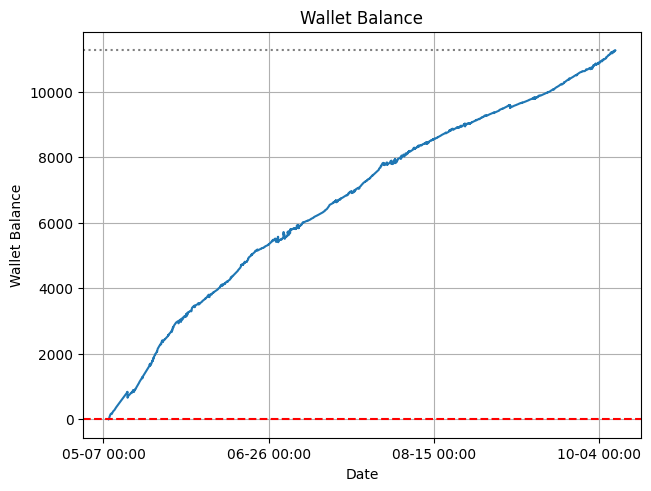

In [18]:
date = df["date"]
wallet_balance_usd = df["wallet_balance_usd"] - start_balance

fig, ax = plt.subplots(1, 1, constrained_layout=True)
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%m-%d %H:%M"))

# Plot the data
ax.plot(
    date,
    wallet_balance_usd,
    label="Wallet Balance",
)
ax.set_title("Wallet Balance")
ax.set_xlabel("Date")
ax.set_ylabel("Wallet Balance")
ax.grid(True)

ax.axhline(y=wallet_balance_usd.iloc[-1], xmax=0.95, linestyle=":", color="gray")
ax.axhline(y=0, xmax=1, linestyle="--", color="red")

ax.xaxis.set_major_locator(plt.MaxNLocator(4))

plt.show()

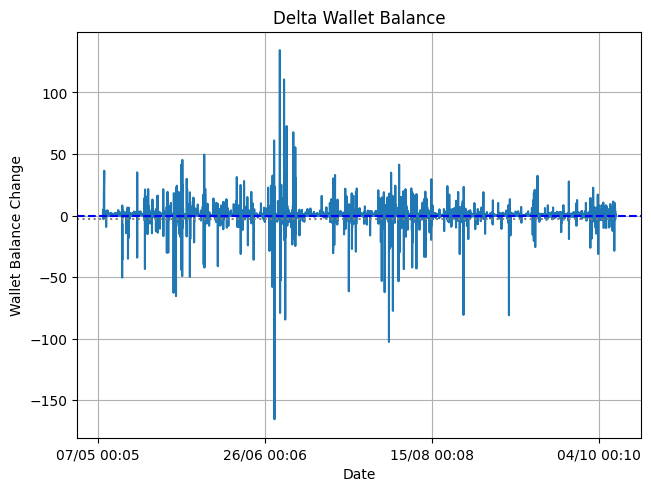

In [19]:
date = df["date"]
delta_wallet_balance_usd = df["wallet_balance_usd"] - df["wallet_balance_usd"].shift(1)

fig, ax = plt.subplots(1, 1, constrained_layout=True)
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%d/%m %H:%m"))

# Plot the data
ax.plot(date, delta_wallet_balance_usd)
ax.set_title("Delta Wallet Balance")
ax.set_xlabel("Date")
ax.set_ylabel("Wallet Balance Change")

# Add block dot line at 1
ax.axhline(y=0, color="b", linestyle="--", label="0")
ax.axhline(y=delta_wallet_balance_usd.iloc[-1], xmax=0.95, linestyle=":", color="gray")

ax.grid(True)
ax.xaxis.set_major_locator(plt.MaxNLocator(4))

plt.show()

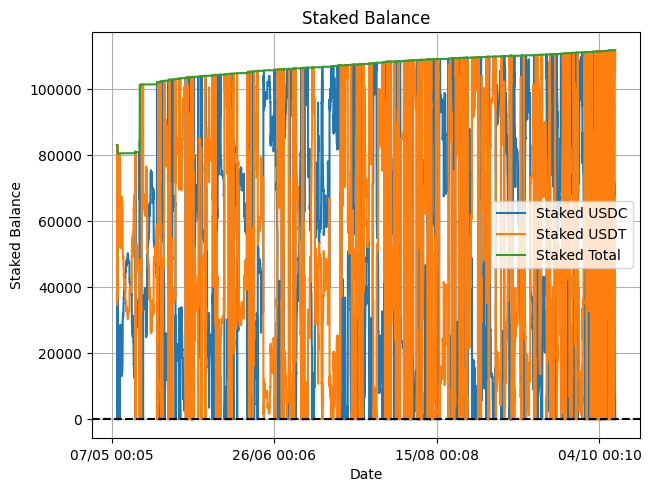

In [20]:
date = df["date"]
staked_usdc = df["moe_sum_x"]
staked_usdt = df["moe_sum_y"]
staked_total = staked_usdc + staked_usdt

fig, ax = plt.subplots(1, 1, constrained_layout=True)
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%d/%m %H:%m"))

# Plot the data
ax.plot(date, staked_usdc, label="Staked USDC")
ax.plot(date, staked_usdt, label="Staked USDT")
ax.plot(date, staked_total, label="Staked Total")
ax.set_title("Staked Balance")
ax.set_xlabel("Date")
ax.set_ylabel("Staked Balance")
ax.grid(True)

ax.xaxis.set_major_locator(plt.MaxNLocator(4))

ax.axhline(y=0, color="black", linestyle="--")

plt.legend()
plt.show()

In [21]:
nb = 10 * 24 * 3

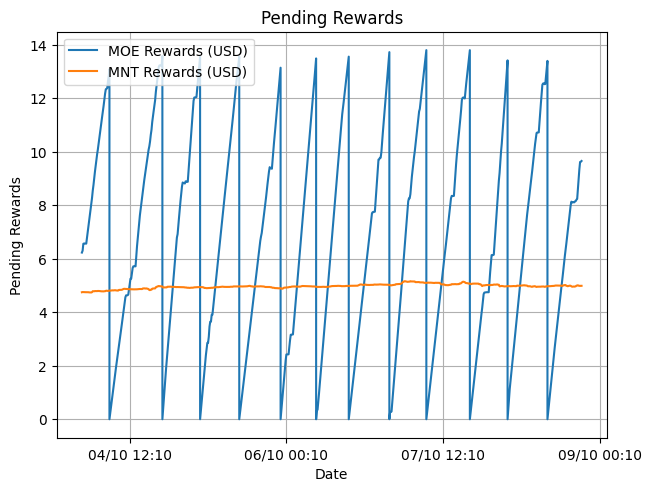

In [22]:
date = df["date"][-nb:]
moe_reward_usd = df["moe_pending_rewards_usd"][-nb:]
mnt_reward_usd = df["mnt_pending_rewards_usd"][-nb:]

fig, ax = plt.subplots(1, 1, constrained_layout=True)
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%d/%m %H:%m"))

# Plot the data
ax.plot(date, moe_reward_usd, label="MOE Rewards (USD)")
ax.plot(date, mnt_reward_usd, label="MNT Rewards (USD)")
ax.set_title("Pending Rewards")
ax.set_xlabel("Date")
ax.set_ylabel("Pending Rewards")

ax.grid(True)
ax.xaxis.set_major_locator(plt.MaxNLocator(4))

plt.legend()
plt.show()

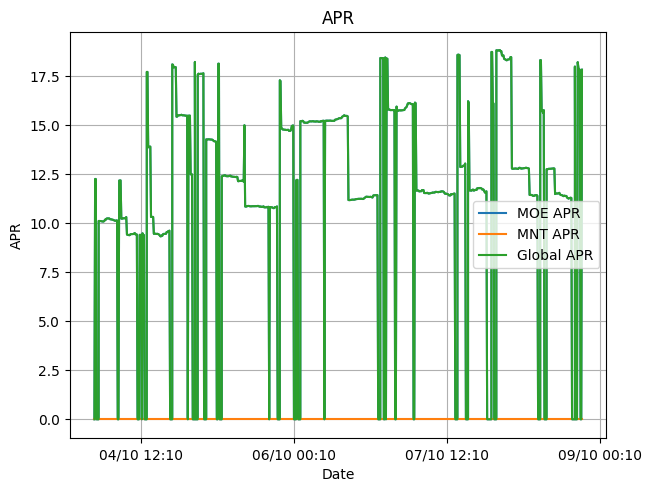

In [23]:
date = df["date"]
moe_apr = df["moe_reward_usd_per_year"] * 100 / df["wallet_balance_usd"]
mnt_apr = df["mnt_reward_usd_per_year"] * 100 / df["wallet_balance_usd"]
in_range = ((df["moe_staked_start_id"] >= df["moe_rewarder_start_id"]) & (df["moe_staked_end_id"] <= df["moe_rewarder_end_id"]))

moe_apr[~in_range] = 0
mnt_apr[~in_range] = 0

global_apr = moe_apr + mnt_apr

fig, ax = plt.subplots(1, 1, constrained_layout=True)
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%d/%m %H:%m"))

# Plot the data
ax.plot(date[-nb:], moe_apr[-nb:], label="MOE APR")
ax.plot(date[-nb:], mnt_apr[-nb:], label="MNT APR")
ax.plot(date[-nb:], global_apr[-nb:], label="Global APR")
ax.set_title("APR")
ax.set_xlabel("Date")
ax.set_ylabel("APR")

ax.grid(True)
ax.xaxis.set_major_locator(plt.MaxNLocator(4))

plt.legend()
plt.show()

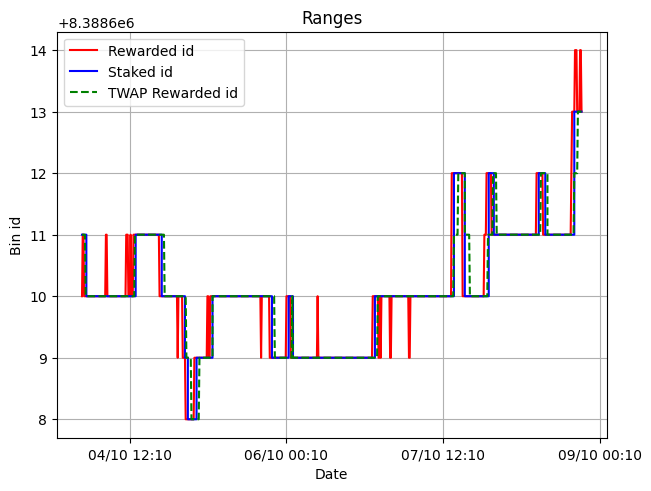

In [24]:
date = df["date"][-nb:]
rewarder_start = df["moe_rewarder_start_id"].apply(lambda x: int(x, 16))[-nb:]
rewarder_end = df["moe_rewarder_end_id"].apply(lambda x: int(x, 16))[-nb:]
staked_start = df["moe_staked_start_id"].apply(lambda x: int(x, 16))[-nb:]
staked_end = df["moe_staked_end_id"].apply(lambda x: int(x, 16))[-nb:]
twap_rewarder_start = df["moe_twap_start_id"].apply(lambda x: int(x, 16))[-nb:]
twap_rewarder_end = df["moe_twap_end_id"].apply(lambda x: int(x, 16))[-nb:]

fig, ax = plt.subplots(1, 1, constrained_layout=True)
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%d/%m %H:%m"))

# Plot the data
ax.plot(date, rewarder_start, label="Rewarded id", color="red")
# ax.plot(date, rewarder_end, label="Rewarded Range End")
ax.plot(date, staked_start, label="Staked id", color="blue")
# ax.plot(date, staked_end, label="Staked Range End")
ax.plot(date, twap_rewarder_start, label="TWAP Rewarded id", color="green", linestyle="--")
# ax.plot(date, twap_rewarder_end, label="TWAP Rewarded Range End")

ax.set_title("Ranges")
ax.set_xlabel("Date")
ax.set_ylabel("Bin id")

ax.grid(True)
ax.xaxis.set_major_locator(plt.MaxNLocator(4))

plt.legend()
plt.show()

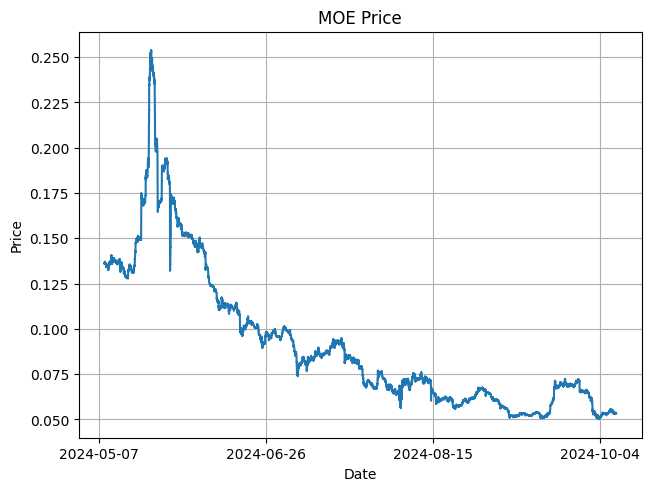

In [25]:
date = df["date"]

moe_reward_usd = df["moe_pending_rewards_usd"]
moe_reward_amount = df["moe_pending_rewards"]

moe_price = moe_reward_usd / moe_reward_amount

fig, ax = plt.subplots(1, 1, constrained_layout=True)

# Plot the data
ax.plot(date, moe_price)
ax.set_title("MOE Price")
ax.set_xlabel("Date")
ax.set_ylabel("Price")

ax.grid(True)
ax.xaxis.set_major_locator(plt.MaxNLocator(4))

plt.show()

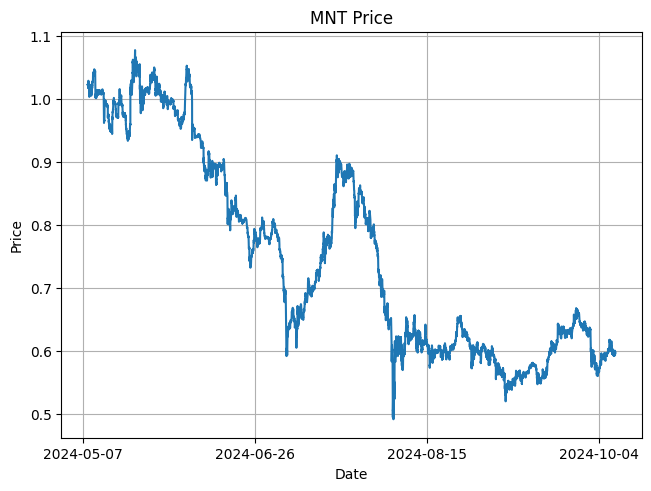

In [26]:
date = df["date"]

mnt_reward_usd = df["mnt_pending_rewards_usd"]
mnt_reward_amount = df["mnt_pending_rewards"]

mnt_price = mnt_reward_usd / mnt_reward_amount

fig, ax = plt.subplots(1, 1, constrained_layout=True)

# Plot the data
ax.plot(date, mnt_price)
ax.set_title("MNT Price")
ax.set_xlabel("Date")
ax.set_ylabel("Price")

ax.grid(True)
ax.xaxis.set_major_locator(plt.MaxNLocator(4))

plt.show()